<a href="https://colab.research.google.com/github/AnnCherk/Introduction-to-ML/blob/main/Ensembles_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [ ]:
import pandas as pd

df = pd.read_csv('electricity_train.csv')

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [ ]:
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("Пропусков в данных нет.")
else:
    print("Обнаружены пропуски в данных.")

Пропусков в данных нет.


In [ ]:
class_counts = df['class'].value_counts()
if len(class_counts) == 2:
    class_1_proportion = class_counts[1] / len(df)
    print(f"Доля элементов класса 1: {class_1_proportion:.3f}")
else:
    print("Классы не сбалансированы или присутствуют не все классы.")

Доля элементов класса 1: 0.425


Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

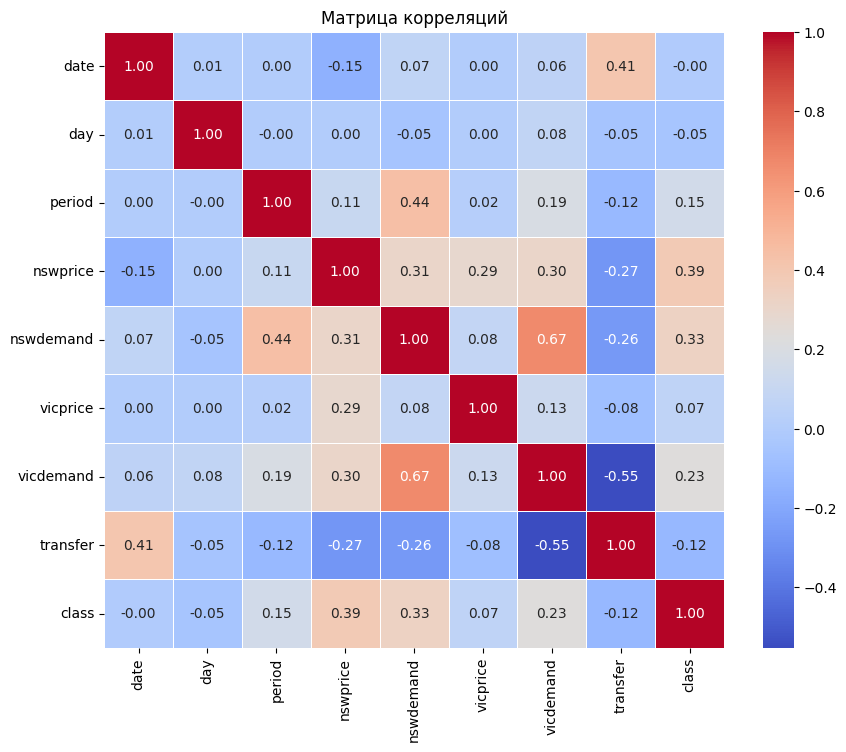

Наиболее коррелированная пара признаков: ('nswdemand', 'vicdemand') с корреляцией 0.6671743250710647


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Строим матрицу корреляций
correlation_matrix = df.corr()

# Визуализируем матрицу корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

# Находим наиболее коррелированные признаки
max_corr = 0
feature_pair = None

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > max_corr:
            max_corr = abs(correlation_matrix.iloc[i, j])
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])

print("Наиболее коррелированная пара признаков:", feature_pair, "с корреляцией", max_corr)

Постройте гистограммы распределений признаков.

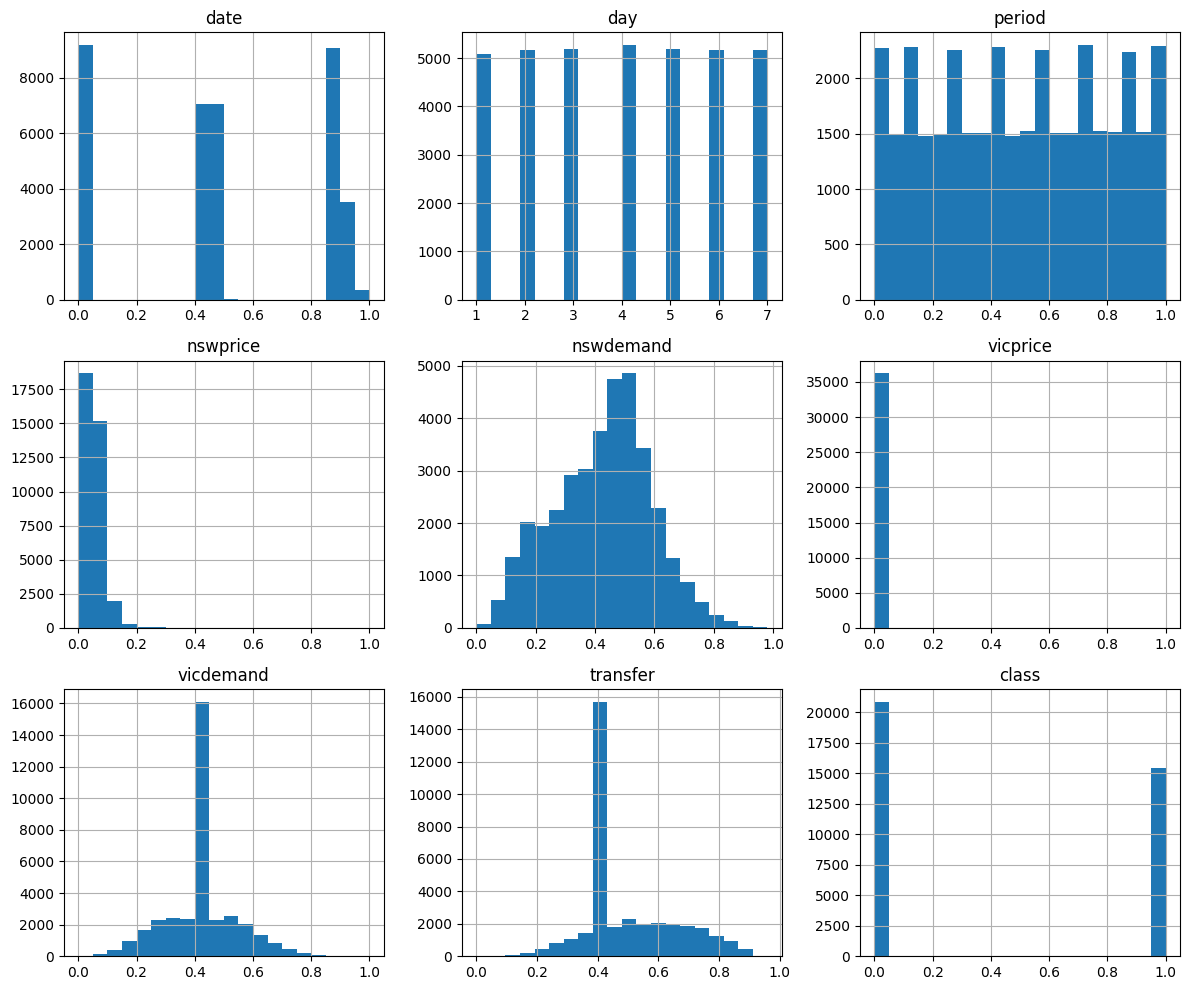

In [ ]:
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
from sklearn.model_selection import train_test_split

# Разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['class']), df['class'], test_size=0.2, random_state=29)

# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Создаем и обучаем модель RandomForestClassifier
model = RandomForestClassifier(random_state=29)
model.fit(X_train, y_train)

# Делаем предсказания на тренировочных данных
train_predictions = model.predict(X_train)

# Выводим classification report
report = classification_report(y_train, train_predictions, digits=3)
print("Classification Report на тренировочных данных:\n", report)

# Определяем точность модели на тренировочных данных
accuracy_train = model.score(X_train, y_train)
print("Точность модели на тренировочных данных:", round(accuracy_train, 3))

Classification Report на тренировочных данных:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     16668
           1      1.000     1.000     1.000     12331

    accuracy                          1.000     28999
   macro avg      1.000     1.000     1.000     28999
weighted avg      1.000     1.000     1.000     28999

Точность модели на тренировочных данных: 1.0


Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [ ]:
from sklearn.model_selection import GridSearchCV

# Определяем параметры для подбора
params_grid = {
    'n_estimators': [100, 300, 500],
    'max_leaf_nodes': list(range(6, 10)),
    'min_samples_leaf': [1, 2, 3]
}

# Создаем экземпляр модели RandomForestClassifier с начальными параметрами
base_model = RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=29
)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=params_grid,
    verbose=4,
    cv=3
)

# Обучаем модель
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.772 total time=   1.7s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.768 total time=   2.3s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   4.5s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.768 total time=   8.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.767 total time=  11.7s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.772 total time=   8.0s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.772 total time=  12.4s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.770 total time=   7.3s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.772 total time=   5.7s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=29),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_leaf_nodes=9, n_estimators=500, n_jobs=-1,
                       random_state=29)

In [ ]:
grid_search.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 1, 'n_estimators': 500}

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
from sklearn.metrics import classification_report

# Делаем предсказания на тренировочных данных с помощью лучшей модели
train_predictions = grid_search.best_estimator_.predict(X_train)

# Выводим classification report
report = classification_report(y_train, train_predictions, digits=3)
print("Classification Report на тренировочных данных:\n", report)

# Определяем точность модели на тренировочных данных
accuracy_train = grid_search.best_estimator_.score(X_train, y_train)
print("Точность модели на тренировочных данных:", round(accuracy_train, 3))

Classification Report на тренировочных данных:
               precision    recall  f1-score   support

           0      0.779     0.876     0.825     16668
           1      0.798     0.665     0.726     12331

    accuracy                          0.786     28999
   macro avg      0.789     0.770     0.775     28999
weighted avg      0.788     0.786     0.783     28999

Точность модели на тренировочных данных: 0.786


Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [ ]:
# Делаем предсказания на тестовых данных с помощью лучшей модели
test_predictions = grid_search.best_estimator_.predict(X_test)

# Выводим classification report
report_test = classification_report(y_test, test_predictions, digits=3)
print("Classification Report на тестовых данных:\n", report_test)

# Определяем точность модели на тестовых данных
accuracy_test = grid_search.best_estimator_.score(X_test, y_test)
print("Точность модели на тестовых данных:", round(accuracy_test, 3))

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0      0.782     0.875     0.826      4192
           1      0.796     0.665     0.725      3058

    accuracy                          0.787      7250
   macro avg      0.789     0.770     0.775      7250
weighted avg      0.788     0.787     0.783      7250

Точность модели на тестовых данных: 0.787


От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
feature_importance = grid_search.best_estimator_.feature_importances_

# Находим индекс признака с максимальной важностью
most_important_index = feature_importance.argmax()

# Находим название самого важного признака
most_important_feature_name = df.drop(columns=['class']).columns[most_important_index]

print("Самый важный признак модели:", most_important_feature_name)

Самый важный признак модели: nswprice


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

# Определяем базовые алгоритмы
log_reg = LogisticRegression(solver='liblinear', random_state=29)
svc = SVC(random_state=29)
sgd = SGDClassifier(random_state=29)

# Создаем VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('svc', svc), ('sgd', sgd)],
    voting='hard'
)

# Обучаем модель
voting_clf.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions_voting = voting_clf.predict(X_test)

# Выводим classification report
report_voting = classification_report(y_test, test_predictions_voting, digits=3)
print("Classification Report на тестовых данных для VotingClassifier:\n", report_voting)

# Определяем точность модели на тестовых данных
accuracy_test_voting = voting_clf.score(X_test, y_test)
print("Точность модели на тестовых данных для VotingClassifier:", round(accuracy_test_voting, 3))


Classification Report на тестовых данных для VotingClassifier:
               precision    recall  f1-score   support

           0      0.720     0.916     0.806      4192
           1      0.816     0.513     0.630      3058

    accuracy                          0.746      7250
   macro avg      0.768     0.714     0.718      7250
weighted avg      0.761     0.746     0.732      7250

Точность модели на тестовых данных для VotingClassifier: 0.746


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Создаем и обучаем модель BaggingClassifier
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
    random_state=29
)
bagging_clf.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions_bagging = bagging_clf.predict(X_test)

# Выводим classification report
report_bagging = classification_report(y_test, test_predictions_bagging, digits=3)
print("Classification Report на тестовых данных для BaggingClassifier:\n", report_bagging)

# Определяем точность модели на тестовых данных
accuracy_test_bagging = bagging_clf.score(X_test, y_test)
print("Точность модели на тестовых данных для BaggingClassifier:", round(accuracy_test_bagging, 3))

Classification Report на тестовых данных для BaggingClassifier:
               precision    recall  f1-score   support

           0      0.822     0.903     0.861      4192
           1      0.847     0.731     0.785      3058

    accuracy                          0.831      7250
   macro avg      0.834     0.817     0.823      7250
weighted avg      0.832     0.831     0.829      7250

Точность модели на тестовых данных для BaggingClassifier: 0.831


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создаем и обучаем модель GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.8,
    random_state=29,
    max_depth=2
)
gb_clf.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions_gb = gb_clf.predict(X_test)

# Выводим classification report
report_gb = classification_report(y_test, test_predictions_gb, digits=3)
print("Classification Report на тестовых данных для GradientBoostingClassifier:\n", report_gb)

# Определяем точность модели на тестовых данных
accuracy_test_gb = gb_clf.score(X_test, y_test)
print("Точность модели на тестовых данных для GradientBoostingClassifier:", round(accuracy_test_gb, 3))


Classification Report на тестовых данных для GradientBoostingClassifier:
               precision    recall  f1-score   support

           0      0.908     0.917     0.913      4192
           1      0.885     0.872     0.879      3058

    accuracy                          0.898      7250
   macro avg      0.897     0.895     0.896      7250
weighted avg      0.898     0.898     0.898      7250

Точность модели на тестовых данных для GradientBoostingClassifier: 0.898


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Создаем базовый классификатор DecisionTreeClassifier
base_classifier = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

# Создаем и обучаем модель AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(
    base_estimator=base_classifier,
    n_estimators=300,
    learning_rate=0.5,
    random_state=29
)
adaboost_clf.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions_adaboost = adaboost_clf.predict(X_test)

# Выводим classification report
report_adaboost = classification_report(y_test, test_predictions_adaboost, digits=3)
print("Classification Report на тестовых данных для AdaBoostClassifier:\n", report_adaboost)

# Определяем точность модели на тестовых данных
accuracy_test_adaboost = adaboost_clf.score(X_test, y_test)
print("Точность модели на тестовых данных для AdaBoostClassifier:", round(accuracy_test_adaboost, 3))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Classification Report на тестовых данных для AdaBoostClassifier:
               precision    recall  f1-score   support

           0      0.926     0.902     0.914      4192
           1      0.870     0.901     0.885      3058

    accuracy                          0.902      7250
   macro avg      0.898     0.902     0.900      7250
weighted avg      0.902     0.902     0.902      7250

Точность модели на тестовых данных для AdaBoostClassifier: 0.902


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Определяем базовые алгоритмы
base_estimators = [
    ('rf', RandomForestClassifier(random_state=29)),
    ('svc', SVC(random_state=29))
]

# Определяем решающий алгоритм
final_estimator = LogisticRegression(random_state=29)

# Создаем и обучаем модель StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)
stacking_clf.fit(X_train, y_train)

# Делаем предсказания на тестовых данных
test_predictions_stacking = stacking_clf.predict(X_test)

# Выводим classification report
report_stacking = classification_report(y_test, test_predictions_stacking, digits=3)
print("Classification Report на тестовых данных для StackingClassifier:\n", report_stacking)

# Определяем точность модели на тестовых данных
accuracy_test_stacking = stacking_clf.score(X_test, y_test)
print("Точность модели на тестовых данных для StackingClassifier:", round(accuracy_test_stacking, 3))

Classification Report на тестовых данных для StackingClassifier:
               precision    recall  f1-score   support

           0      0.912     0.922     0.917      4192
           1      0.891     0.878     0.885      3058

    accuracy                          0.903      7250
   macro avg      0.902     0.900     0.901      7250
weighted avg      0.903     0.903     0.903      7250

Точность модели на тестовых данных для StackingClassifier: 0.903


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Загрузка тренировочных данных
train_data = pd.read_csv("electricity_train.csv")

# Разделение на признаки и целевую переменную
X_train = train_data.drop(columns=["class"])
y_train = train_data["class"]

# Обучение модели AdaBoostClassifier
base_estimator = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
adaboost_clf = AdaBoostClassifier(
    base_estimator=base_estimator,
    n_estimators=8000,
    learning_rate=0.5,
    random_state=29
)
adaboost_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=3),
                   learning_rate=0.5, n_estimators=8000, random_state=29)

In [ ]:
test_data = pd.read_csv("electricity_reserved.csv")

# Предсказания на тестовых данных
X_test = test_data  # В тестовом файле нет целевой переменной
test_predictions = adaboost_clf.predict(X_test)

In [ ]:
import pandas as pd

# Преобразование массива в датафрейм
df_test_predictions = pd.DataFrame(test_predictions, columns=['Prediction'])

In [ ]:
print('[', end='')
for i in range(len(test_predictions)):
    print(test_predictions[i], end='')
    if i != len(test_predictions) - 1:
        print(',', end=' ')
print(']')

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 